# Analyses de la résilience d'un essaim de nano-satellites

## Import packages

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.spatial.distance import cdist

from swarm_sim import *



%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [3]:
PATH = 'Traces.csv'

df = pd.read_csv(PATH, sep=',', header=None)
satellites = {}

for i in range(0,100):
    sat = df.iloc[3*i : 3*i+3].copy()
    sat['coords'] = ['x','y','z']
    satellites[i] = sat.set_index('coords', drop=True)

satellites[0]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [4]:
RANGE = 60000 #CHANGER AU BESOIN

list_satellites = []

for i in range(len(satellites)):
    obj_sat = Node.__new__(Node)
    obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])
    list_satellites.append(obj_sat)

swarm = Swarm.__new__(Swarm)
swarm.__init__(RANGE, list_satellites)
graph = swarm.swarm_to_nxgraph()

/tmp/ipykernel_18212/2680415099.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])


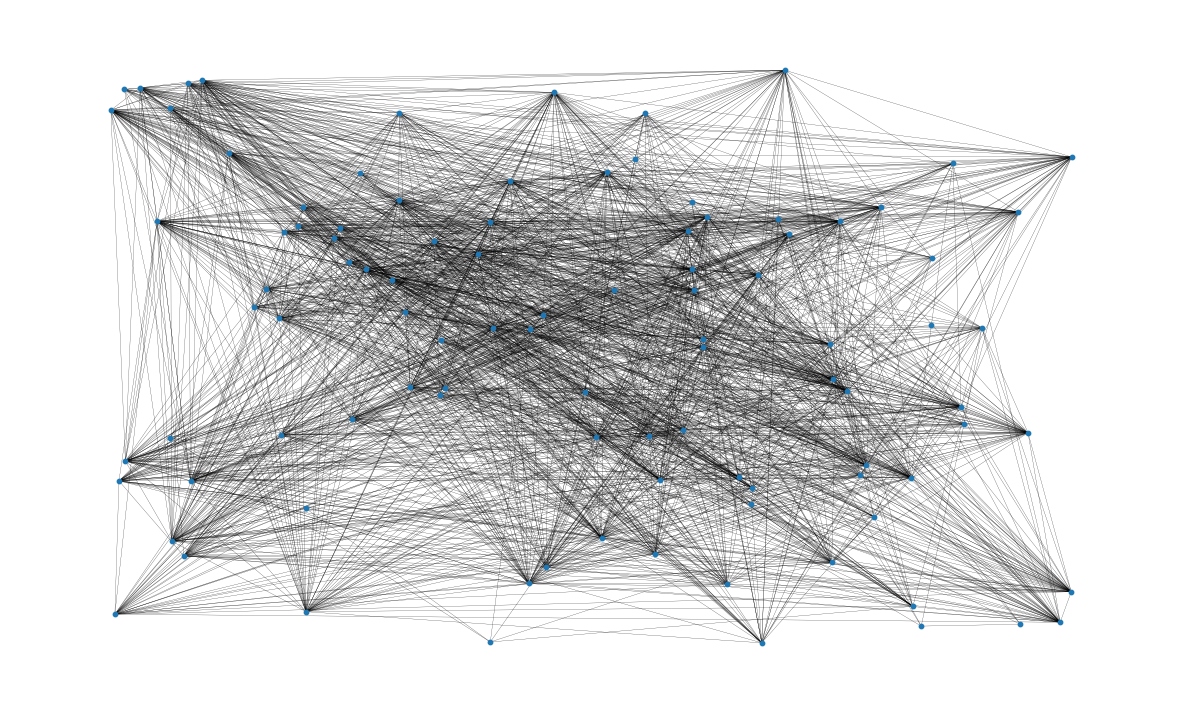

In [5]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(graph, pos=nx.random_layout(graph), ax=ax, **plot_options)

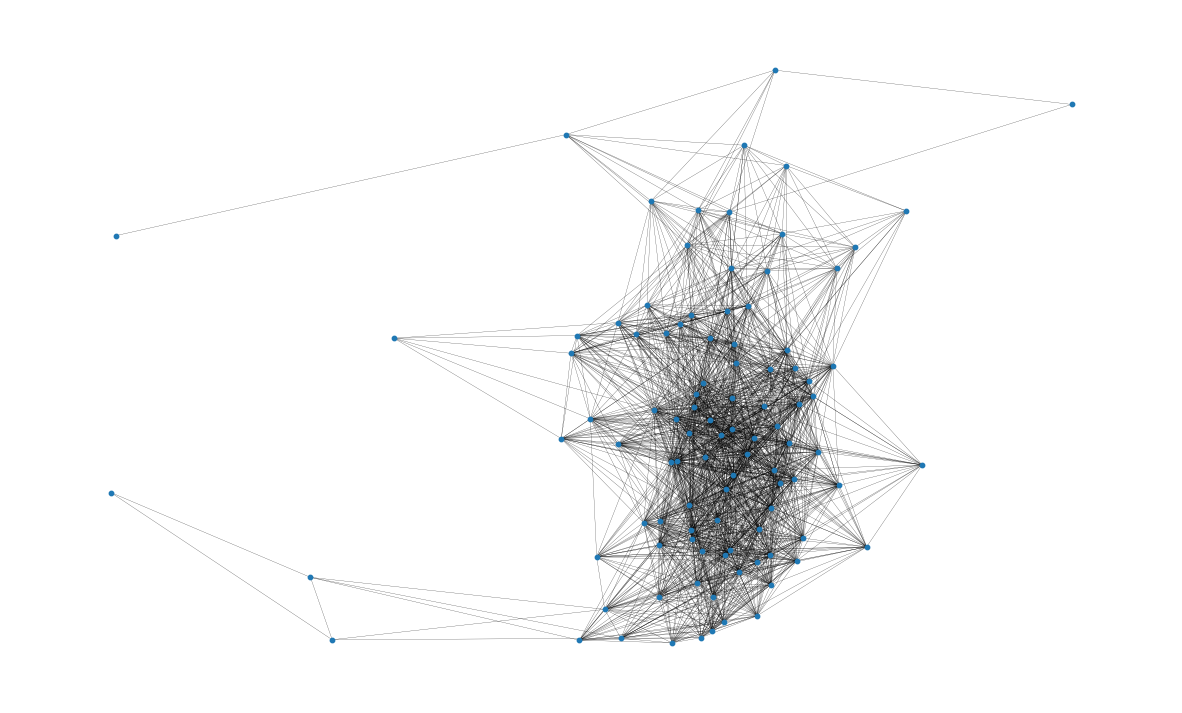

In [6]:
pos = nx.spring_layout(graph, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(graph, pos=pos, ax=ax, **plot_options)

## Robert Ludo

Voir si on supprime un nanosatellite qu'est ce que ça fait

In [10]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

def analyse_suppression_aleatoire(df, nb_a_supprimer, timestep=5000, threshold_km=60.0, seed=None):
    """
    Supprime aléatoirement un groupe de satellites et analyse l'impact sur les connexions.

    Paramètres :
        - df : DataFrame (300 lignes, 10000 colonnes)
        - timestep : index de la colonne temporelle (0 à 9999)
        - nb_a_supprimer : nombre de satellites à supprimer aléatoirement
        - threshold_km : distance maximale pour considérer deux satellites comme connectés
        - seed : graine aléatoire pour reproductibilité

    Retour :
        - Liste des satellites supprimés
        - DataFrame avec connexions avant/après/delta
    """

    np.random.seed(seed)
    N = 100  # nombre de satellites
    indices_supprimes = sorted(np.random.choice(N, nb_a_supprimer, replace=False))

    # Récupération des coordonnées
    sat_coords = np.zeros((N, df.shape[1], 3))
    for i in range(N):
        sat_coords[i, :, 0] = df.iloc[i*3 + 0]
        sat_coords[i, :, 1] = df.iloc[i*3 + 1]
        sat_coords[i, :, 2] = df.iloc[i*3 + 2]

    def compute_adjacency(pos, threshold):
        dists = cdist(pos, pos)
        return (dists <= threshold) & (dists > 0)

    def count_connections(adj):
        return np.sum(adj, axis=1)

    # Avant suppression
    pos_full = sat_coords[:, timestep, :]
    adj_full = compute_adjacency(pos_full, threshold_km)
    conn_full = count_connections(adj_full)

    # Suppression
    mask = np.ones(N, dtype=bool)
    mask[indices_supprimes] = False
    pos_reduced = pos_full[mask]
    adj_reduced = compute_adjacency(pos_reduced, threshold_km)
    conn_reduced = count_connections(adj_reduced)

    # Résultats
    data = []
    reduced_index = 0
    for i in range(N):
        if i in indices_supprimes:
            data.append([i, conn_full[i], None, None])
        else:
            delta = conn_full[i] - conn_reduced[reduced_index]
            data.append([i, conn_full[i], conn_reduced[reduced_index], delta])
            reduced_index += 1

    df_result = pd.DataFrame(data, columns=["Satellite", "Connexions (avec)", "Connexions (sans)", "Delta"])
    return indices_supprimes, df_result


In [12]:
df = pd.read_csv("Traces.csv", header=None)
supprimes, resultats = analyse_suppression_aleatoire(df, nb_a_supprimer=5, timestep=5000,  seed=42)
print("Satellites supprimés :", supprimes)
display(resultats.head())

Satellites supprimés : [np.int64(44), np.int64(45), np.int64(53), np.int64(70), np.int64(83)]


,Satellite,Connexions (avec),Connexions (sans),Delta
0,0,0,0.0,0.0
1,1,0,0.0,0.0
2,2,0,0.0,0.0
3,3,0,0.0,0.0
4,4,0,0.0,0.0


# Robustesse

Actually, there are bridges in the network. Now the edges that are bridges will be saved in a list and the number of them is printed:

In [16]:
bridges = list(nx.bridges(G))
len(bridges)

0

The existence of so many bridges is due to the fact that this network only contains the spotlight nodes and the friends of them. As a result, some friends of spotlight nodes are only connected to a spotlight node, making that edge a bridge.

Also, the edges that are local bridges are saved in a list and their number is printed. In detaill, an edge joining two nodes $C$ and $D$ 
in a graph is a local bridge, if its endpoints $C$ and $D$ have no friends in common. Very importantly, an edge that is a bridge is also a local bridge. Thus, this list contains all the above bridges as well:

In [17]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

0

Showcasing the bridges and local bridges in the network now. The bridges can be seen with the red color and the local bridges with the green color. Black edges are neither local bridges nor bridges.

* It is clear that all the bridges concern nodes that are only connected to a spotlight node (have a degree of $1$)

(-0.9556550397616517,
 1.0633890724227726,
 -1.0306564545354944,
 1.096697926406452)

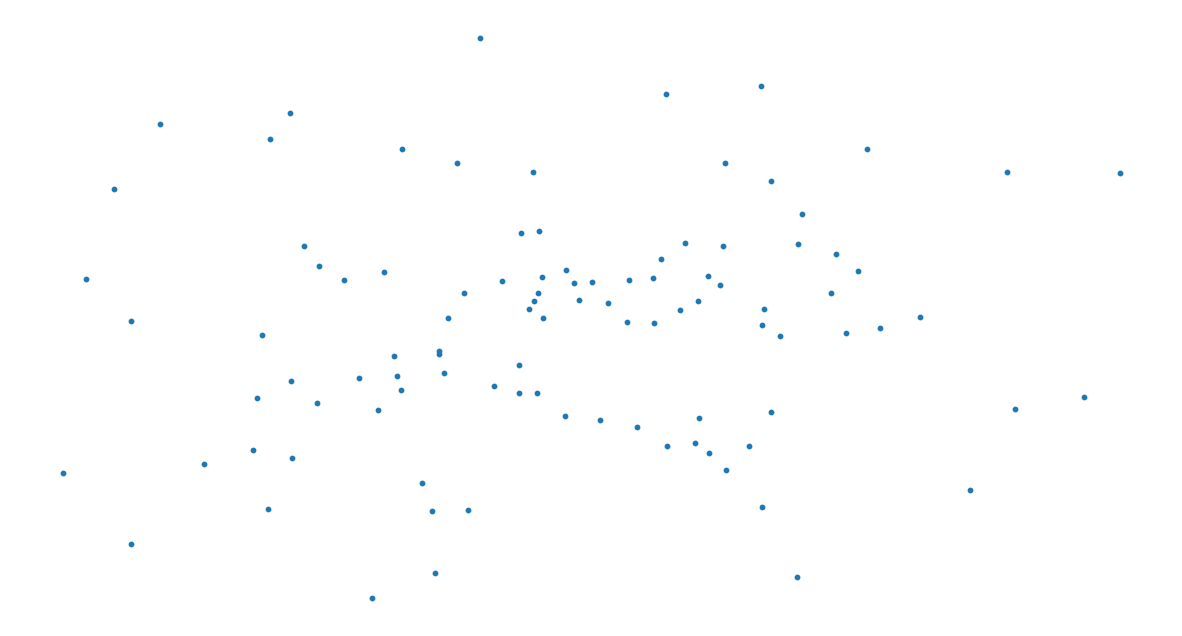

In [18]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")